# FX Appreciation

In [55]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data import COUNTRIES, get_all_data_and_labels
from indicators import *
from signal_math import *
from stats import *
from utils import *

plt.rcParams["figure.figsize"] = (12, 4)

# Initialize the data
all_data, all_labels = get_all_data_and_labels()
all_data_clean, all_labels_clean = get_all_data_and_labels(cleaned=True)

for i, label in enumerate(all_labels):
    vars()[label] = all_data[i]
    
for i, label in enumerate(all_labels_clean):
    vars()[label] = all_data_clean[i]
    
print(*all_labels, sep='\n')

# Get daily returns benchmark
bond_rets_daily = bond_rets_local_fx.pct_change()

bond_rets_local_fx
equity_prices
curr_acct_nom_usd
curr_acct_pct_gdp
fx_trd_wts_nom
fx_trd_wts_real
fx_vs_usd
fx_to_usd
gdp_nom
gdp_real
short_rates
long_rates
core_cpi_sa
m1_usd
m2_usd
m3_usd
inflation_rate_annual


The prospectus hypothesizes that six-month FX appreciations are positively related to bond performance through lower inflation and lower rates.

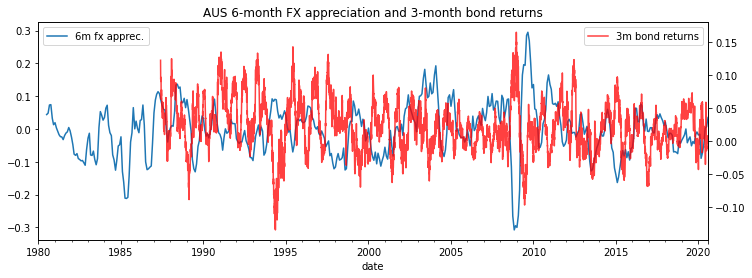

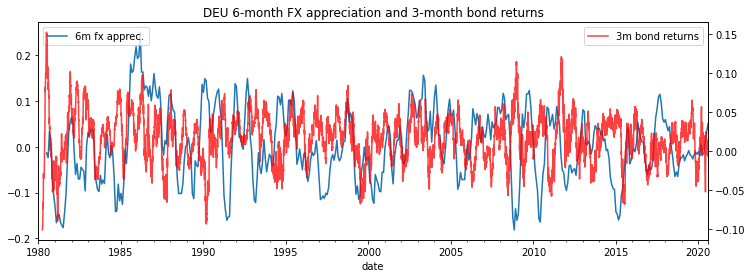

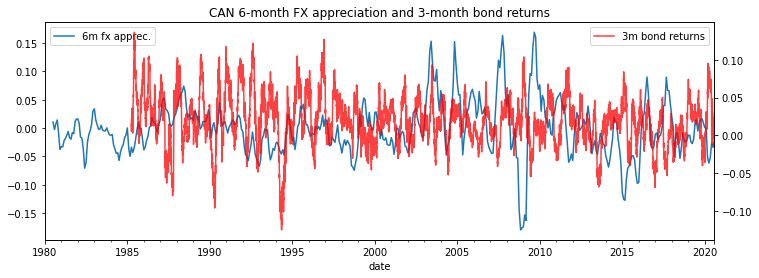

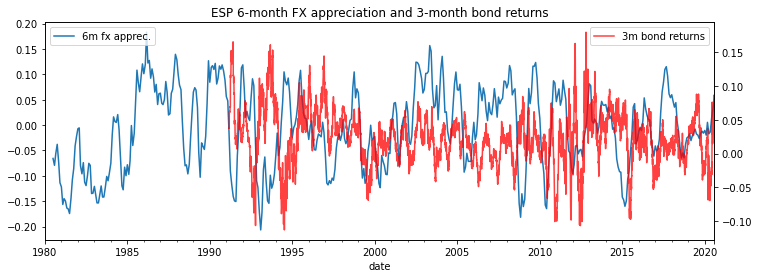

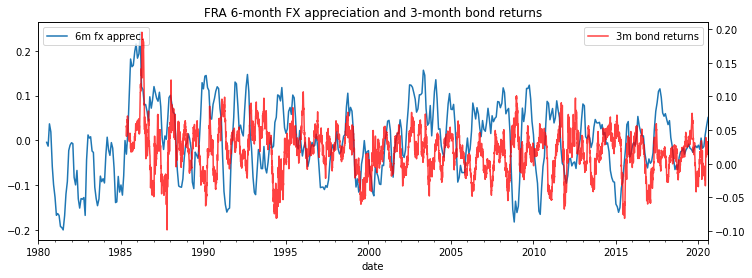

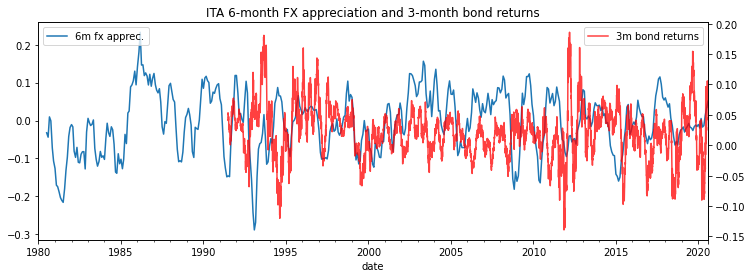

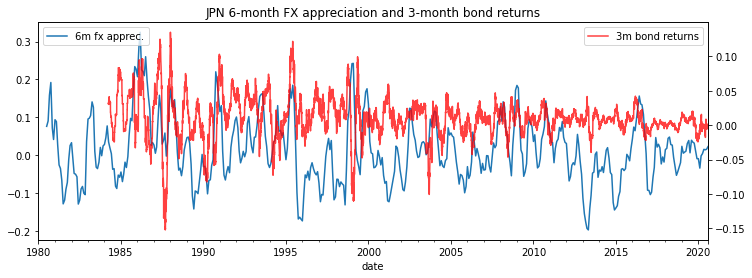

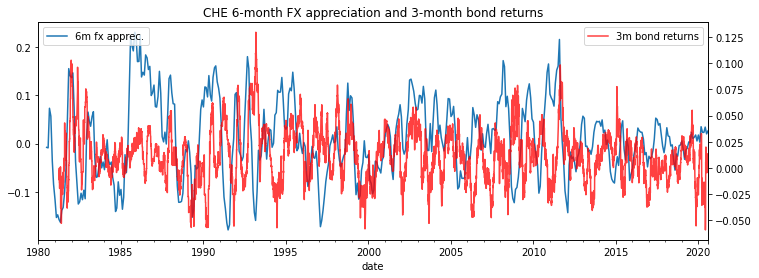

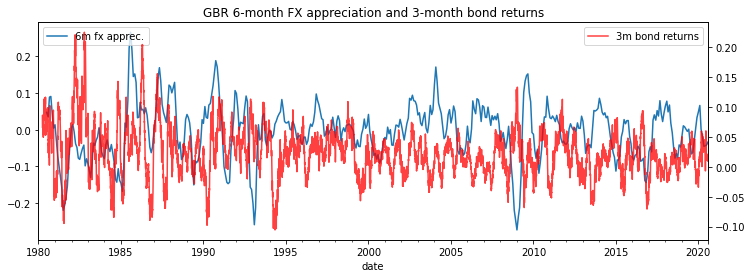

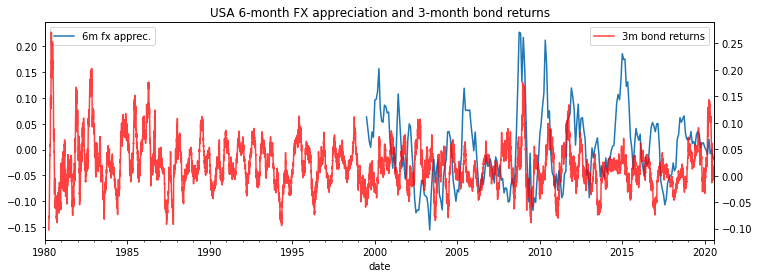

In [69]:
fx_apprec_6m = fx_to_usd.pct_change(6)
bond_rets_3m = bond_rets_local_fx.pct_change(3 * WEEKDAYS_PER_MONTH)

for country in fx_apprec_6m:
    fig, ax = plt.subplots()
    fx_apprec_6m[country].plot()
    ax2 = bond_rets_3m[country].plot(style='red', alpha=0.75, secondary_y=True)
    ax.set_title(f'{country} 6-month FX appreciation and 3-month bond returns')
    ax.legend(['6m fx apprec.'], loc='upper left')
    ax2.legend(['3m bond returns'], loc='upper right')
    

There is potentially some sort of extremely lagged relationship. Look at bond returns in CHE 6 months in the future for example:

Correlation: 0.1656415228684338


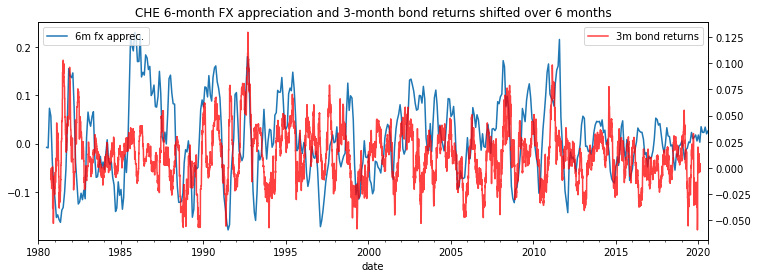

In [89]:
country = 'CHE'
fig, ax = plt.subplots()
fx_apprec_6m[country].plot()
ax2 = bond_rets_3m[country].shift(-6 * WEEKDAYS_PER_MONTH).plot(
    style='red', alpha=0.75, secondary_y=True
)
ax.set_title(f'{country} 6-month FX appreciation and 3-month bond returns shifted over 6 months')
ax.legend(['6m fx apprec.'], loc='upper left')
ax2.legend(['3m bond returns'], loc='upper right')

print('Correlation:', compute_corrcoef(
    fx_apprec_6m[country], 
    bond_rets_3m[country].shift(-6 * WEEKDAYS_PER_MONTH)
))


Considering the number of datapoints, this is could be a fairly significant correlation.

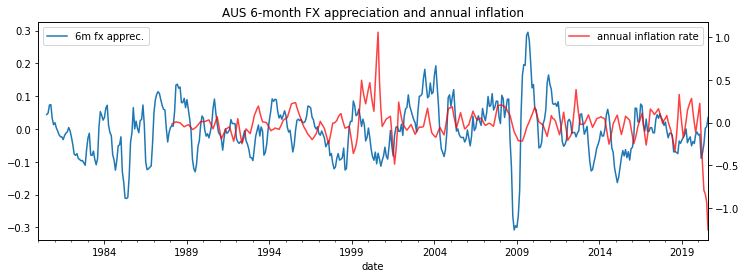

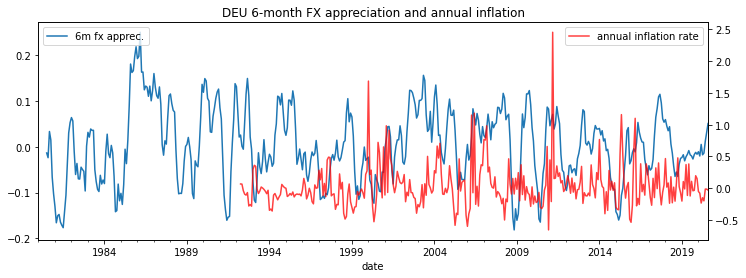

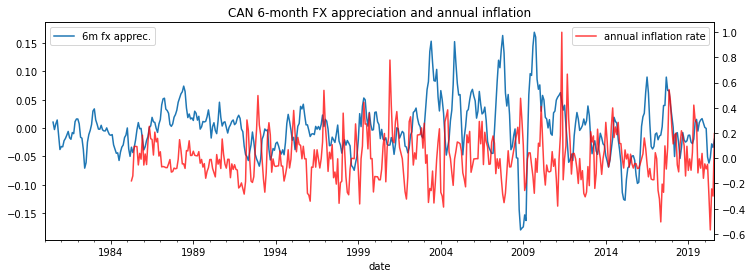

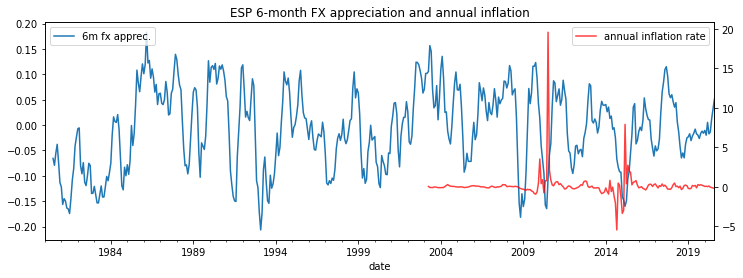

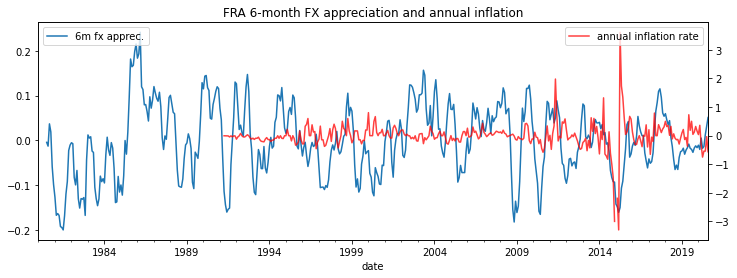

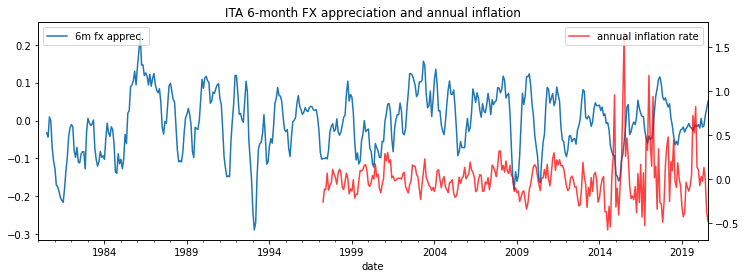

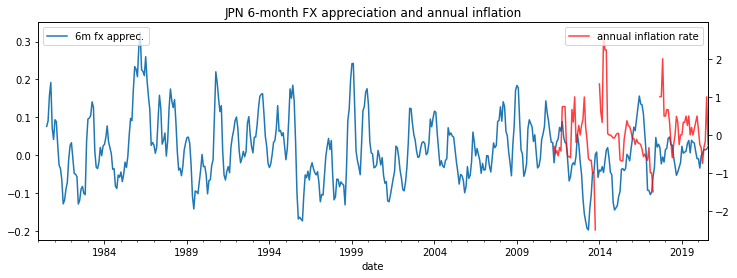

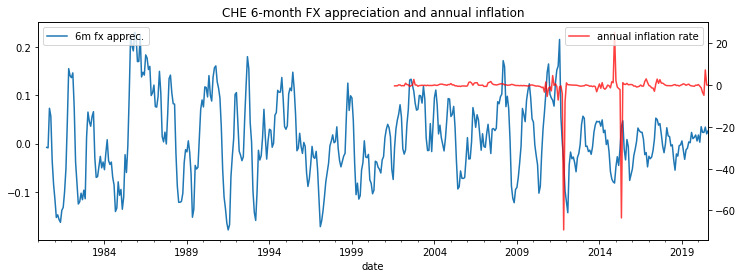

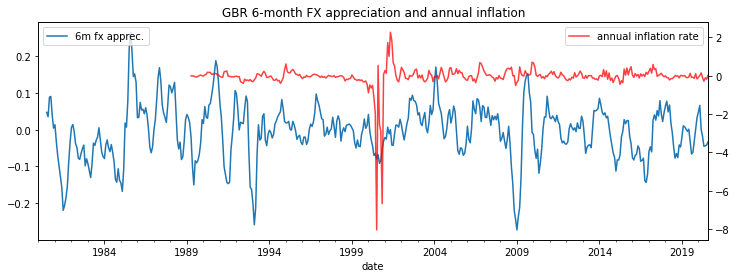

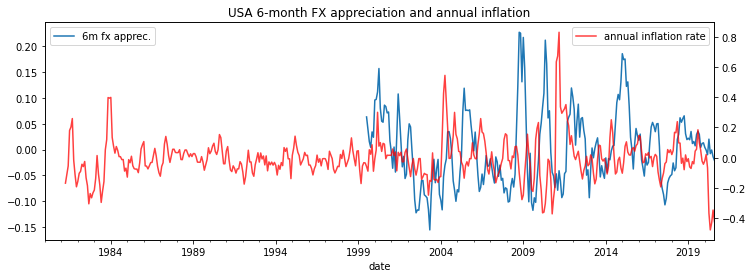

In [99]:
inflation_change_3m = inflation_rate_annual.pct_change(3)
for country in fx_apprec_6m:
    fig, ax = plt.subplots()
    fx_apprec_6m[country].plot()
    ax2 = inflation_change_3m[country].plot(style='red', alpha=0.75, secondary_y=True)
    ax.set_title(f'{country} 6-month FX appreciation and annual inflation')
    ax.legend(['6m fx apprec.'], loc='upper left')
    ax2.legend(['annual inflation rate'], loc='upper right')
    

There appears to be a possible slight relationship in some countries, although the plots are often thrown by extreme values. Certainly, nothing conclusive.

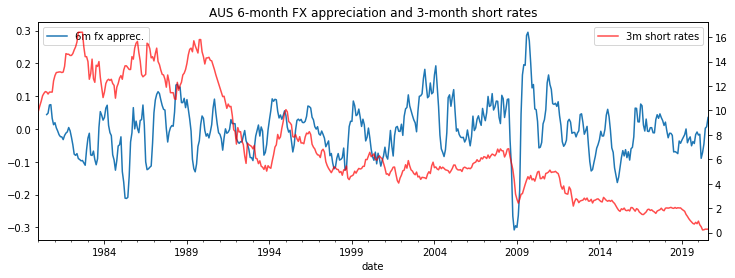

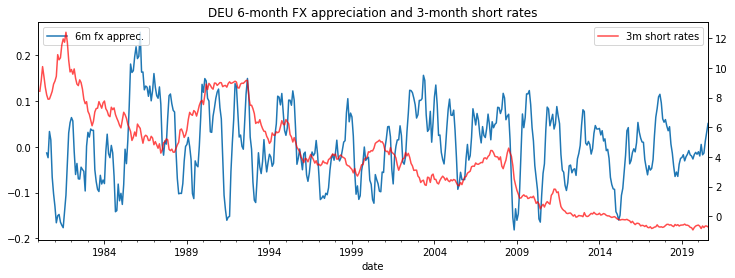

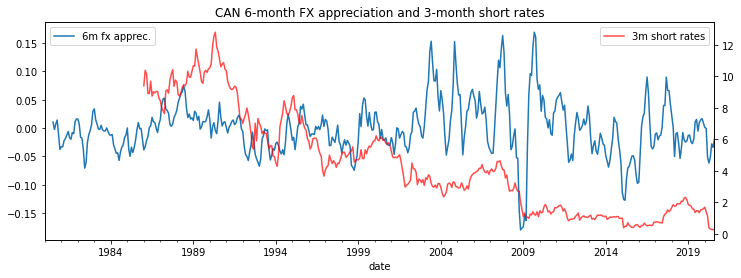

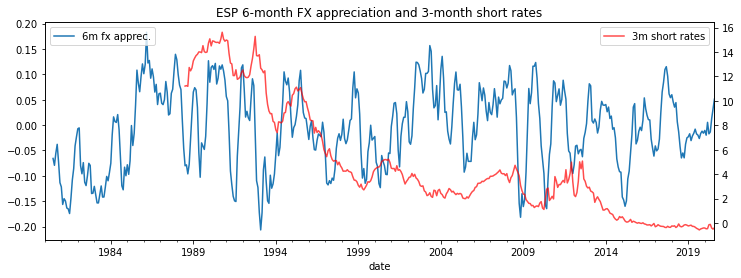

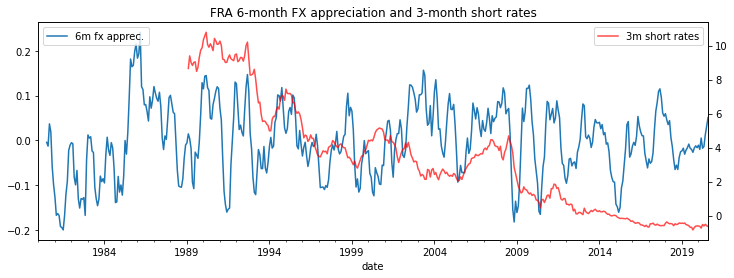

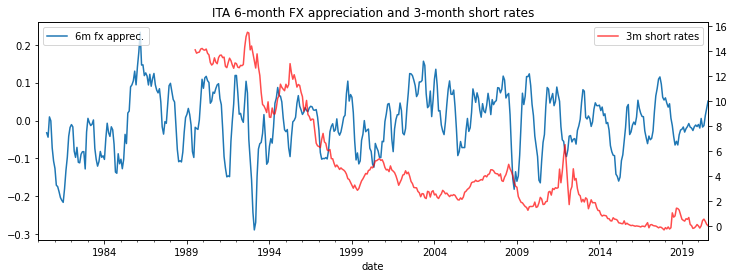

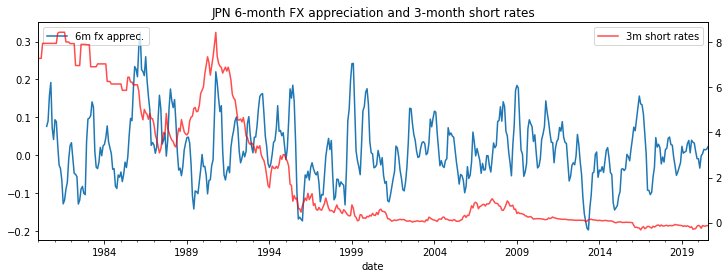

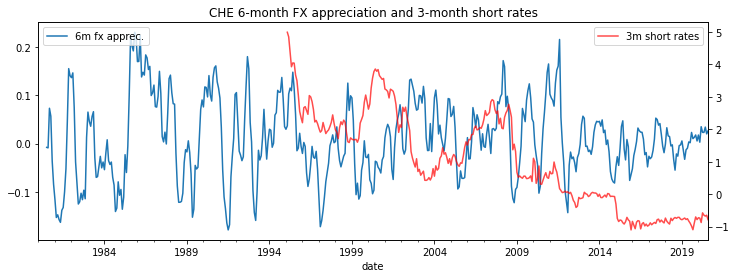

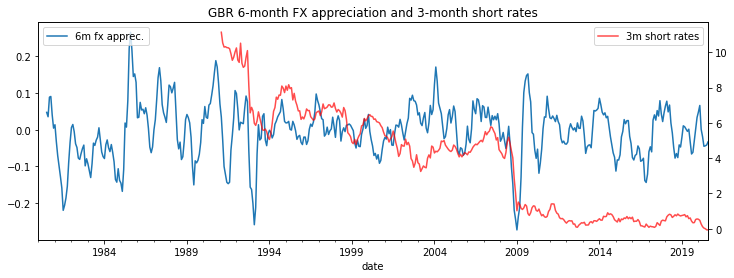

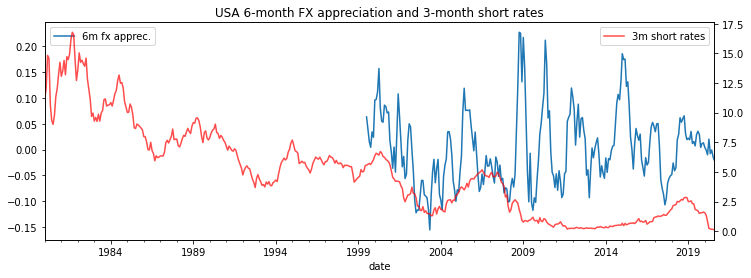

In [105]:
for country in fx_apprec_6m:
    fig, ax = plt.subplots()
    fx_apprec_6m[country].plot()
    ax2 = short_rates[country].plot(style='red', alpha=0.7, secondary_y=True)
    ax.set_title(f'{country} 6-month FX appreciation and 3-month short rates')
    ax.legend(['6m fx apprec.'], loc='upper left')
    ax2.legend(['3m short rates'], loc='upper right')
    

It doesn't appear to be the case that appreciating currencies lead to lower interest rates.

## FX Appreciation Indicator

Keep in mind what we are competing against:

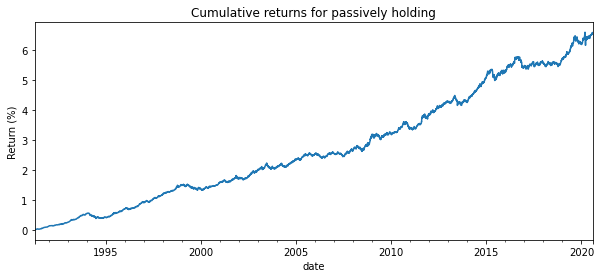

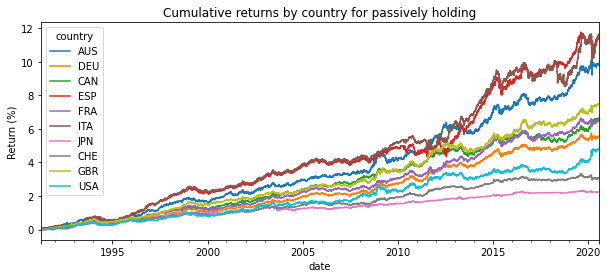

In [2]:
# Cumulative returns from holding
((1 + bond_rets_daily.dropna().mean(axis=1)).cumprod() - 1).plot(
    title='Cumulative returns for passively holding',
    ylabel='Return (%)'
)

((1 + bond_rets_daily.dropna()).cumprod() - 1).plot(
    title='Cumulative returns by country for passively holding',
    ylabel='Return (%)'
)

plt.show()

I implement the prospectus' component for FX appreciation as follows:

- Compute $\Delta_{w} \text{FX} = \text{w-month percent change in FX rate vs. USD}$

- Compute the relative premium for each country by subtracting the global average

- Standardize that relative premium to each country's history of the indicator

I end up using a 4-month window, which seems to work a little better than 6-month.

Total cumulative return: 0.14864615807548787
Cumulative return by country: country
AUS    0.117654
DEU    0.081684
CAN    0.257630
ESP    0.212825
FRA    0.369401
ITA    0.336597
JPN   -0.120994
CHE    0.145889
GBR   -0.029808
USA    0.026873
dtype: float64


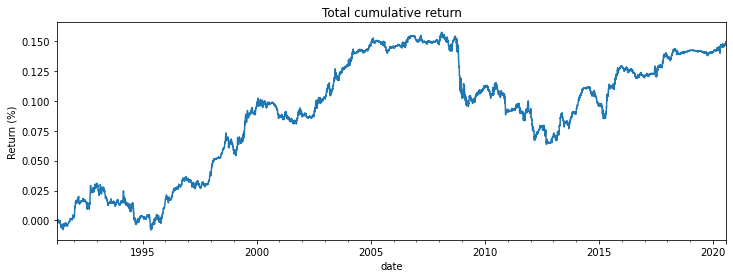

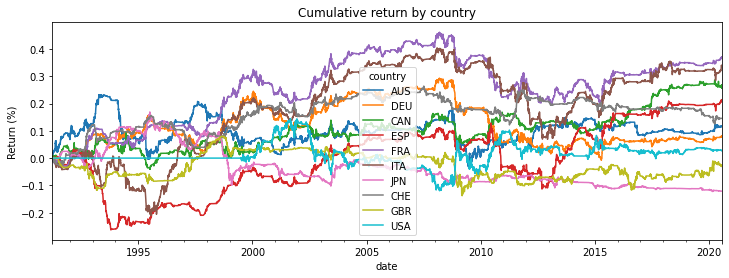

In [116]:
# Compute the signals (and indicators)
inds, sigs = test_indicator(
    fx_appreciation_indicator,
    index=fx_to_usd.index,
    data=(fx_to_usd,),
    kwargs={'window': 4}
)

# Calculate returns
total_rets, country_rets = calculate_returns(*make_comparable(sigs, bond_rets_daily))
print('Total cumulative return:', (1 + total_rets).product() - 1)
print('Cumulative return by country:', (1 + country_rets).product() - 1)

# Plot
((1 + total_rets).cumprod() - 1).plot(
    title='Total cumulative return',
    ylabel='Return (%)'
)
((1 + country_rets).cumprod() - 1).plot(
    title='Cumulative return by country',
    ylabel='Return (%)'
)
plt.show()

Again, the signals are relatively weak, so we can get higher returns by simply boosting the signal, but this is likely just a function of the returns of going long on the market, not the accuracy of the indicator.